In [19]:
import pickle
import pandas as pd
import pandas as pd
import numpy as np
import os
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx
from tqdm import tqdm
import sys
from models.ginconv import GINConvNet
import torch
from torch_geometric.data import Data

with open("esm1b_protein_embeddings.pkl", "rb") as f:
    protein_embeddings = pickle.load(f)
    
print(len(protein_embeddings))

pharos_load = pd.read_csv("data/pharos_with_ids.csv")
davis_load = pd.concat([
    pd.read_csv("data/davis_b3_test.csv"),
    pd.read_csv("data/davis_b3_train.csv")
], ignore_index=True)

davis_protein_ids = set(davis_load["protein_id"])
pharos_protein_ids = set(pharos_load["prot_id"])

davis_protein_embeddings = {pid: protein_embeddings[pid] for pid in davis_protein_ids if pid in protein_embeddings}
pharos_protein_embeddings = {pid: protein_embeddings[pid] for pid in pharos_protein_ids if pid in protein_embeddings}

print(f"{len(davis_protein_embeddings)} DAVIS proteins with embeddings")
print(f"{len(pharos_protein_embeddings)} PHAROS proteins with embeddings")

def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    
    c_size = mol.GetNumAtoms()
    
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])
        
    return c_size, features, edge_index

# Load DAVIS drug and protein sequences
davis_drugs = pd.read_csv("data/davis_b3_drugs.csv")

# Load PHAROS sequences (already matched)
pharos_load = pd.read_csv("data/pharos_with_ids.csv")
davis_load = pd.concat([
    pd.read_csv("data/davis_b3_test.csv"),
    pd.read_csv("data/davis_b3_train.csv")
], ignore_index=True)
davis_load["drug_id"] = davis_load["drug_id"].astype(str).str.strip()
davis_drugs["drug_id"] = davis_drugs["drug_id"].astype(str).str.strip()

davis_drug_ids = set(davis_load["drug_id"])
pharos_drug_ids = set(pharos_load["drug_id"])

# Filter DAVIS drugs to only those used in davis_df
filtered_davis_drugs = davis_drugs[davis_drugs["drug_id"].isin(davis_drug_ids)].rename(
    columns={"drug_id": "drug", "drug_seq": "smiles"}
)[["drug", "smiles"]]
print(len(filtered_davis_drugs))

# Get PHAROS drugs
pharos_drugs = pharos_load.rename(
    columns={"drug_id": "drug", "drug_smile": "smiles"}
)[["drug", "smiles"]]
print(len(pharos_drugs))

# Combine and deduplicate
drug_smiles_dict = pd.concat([filtered_davis_drugs, pharos_drugs]) \
    .drop_duplicates("drug") \
    .set_index("drug")["smiles"] \
    .to_dict()

smile_graph = {}
for drug_id, smile in tqdm(drug_smiles_dict.items()):
    try:
        graph_data = smile_to_graph(smile)
        smile_graph[drug_id] = graph_data
    except Exception as e:
        print(f"[{drug_id}] Error: {e}")

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))

# Instantiate model with default args (match training!)
model = GINConvNet()

# Load saved weights
model.load_state_dict(torch.load("saved_models/final_model_GINConvNet_davis_b3_1.pt", map_location="cpu"))

# Set to eval mode
model.eval()

drug_embeddings = {}

for drug_id, (num_atoms, features, edge_index) in smile_graph.items():
    x = torch.tensor(features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    batch = torch.zeros(x.shape[0], dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, batch=batch)

    with torch.no_grad():
        emb = model.extract_drug_embedding(data)
        drug_embeddings[drug_id] = emb.squeeze().numpy()

print(len(drug_embeddings))
# Keep only drug_ids that exist in the embeddings dict
davis_drug_embeddings = {
    did: drug_embeddings[did]
    for did in davis_drug_ids if did in drug_embeddings
}
print(len(davis_drug_embeddings))
pharos_drug_embeddings = {
    did: drug_embeddings[did]
    for did in pharos_drug_ids if did in drug_embeddings
}
print(len(pharos_drug_embeddings))

470
379 DAVIS proteins with embeddings
28 PHAROS proteins with embeddings
68
495


100%|██████████| 277/277 [00:00<00:00, 1164.95it/s]


277
68
209


In [20]:
def compute_continuous_hull_distance(unblinded, blinded_subset):
    from shapely.geometry import Point
    from shapely.ops import nearest_points
    from scipy.spatial import ConvexHull, Delaunay
    import numpy as np
    from shapely.geometry import Polygon

    # === Build hull from unblinded set ===
    hull = ConvexHull(unblinded)
    polygon = Polygon(unblinded[hull.vertices])
    delaunay = Delaunay(unblinded[hull.vertices])

    # === Step 1: Compute max inside distance from unblinded set only ===
    unblinded_dists = []
    for point in unblinded:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        if is_inside:
            unblinded_dists.append(dist)

    max_inside = max(unblinded_dists) if unblinded_dists else 0.0

    # === Step 2: Compute adjusted distances for blinded points ===
    dists = []
    is_inside_list = []

    for point in blinded_subset:
        pt = Point(point)
        nearest = nearest_points(pt, polygon.boundary)[1]
        dist = pt.distance(nearest)
        is_inside = delaunay.find_simplex([point])[0] >= 0
        dists.append(dist)
        is_inside_list.append(is_inside)

    dists = np.array(dists)
    is_inside = np.array(is_inside_list)

    adjusted_dist = dists.copy()
    adjusted_dist[is_inside] = max_inside - dists[is_inside]   # inside: 0 = deepest
    adjusted_dist[~is_inside] = dists[~is_inside] + max_inside  # outside: continues upward

    return adjusted_dist, is_inside



def estimate_sparse_weight(unblinded, blinded_subset, k=20):
    import numpy as np
    from sklearn.neighbors import NearestNeighbors

    # Step 1: Fit k-NN on unblinded
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(unblinded)

    # Step 2: Compute unblinded point densities
    dists_unblinded, _ = nn.kneighbors(unblinded)
    density_unblinded = 1 / (dists_unblinded.mean(axis=1) + 1e-8)
    log_density_unblinded = np.log(density_unblinded + 1e-8)

    # Step 3: Compute blinded point densities
    dists_blinded, _ = nn.kneighbors(blinded_subset)
    density_blinded = 1 / (dists_blinded.mean(axis=1) + 1e-8)
    log_density_blinded = np.log(density_blinded + 1e-8)

    # Step 4: Compute z-score sparsity on log scale (higher = more sparse)
    mu = np.mean(log_density_unblinded)
    sigma = np.std(log_density_unblinded) + 1e-8
    sparsity_z = (mu - log_density_blinded) / sigma

    return sparsity_z


# === Final hybrid ERS computation ===
def compute_ERS_for_points(unblinded, blinded_subset, gamma=5.0, k=5, merged=None, use_cspd=True):
    cspd = None
    continuous_hull_distance, is_inside = compute_continuous_hull_distance(unblinded, blinded_subset)
    # Possibly override with CSPD if requested
    if use_cspd and merged is not None:
        cspd = np.abs((merged["Unblinded_Prediction"] - merged["Blinded_Prediction"]))
        dists_for_ERS = cspd
    else:
        dists_for_ERS = continuous_hull_distance

    # Sparsity
    sparsity_weights = np.maximum(estimate_sparse_weight(unblinded, blinded_subset, k=k), 1e-3) #THINK ABOUT THIS PART MORE

    # ERS
    print(len(dists_for_ERS))
    print(len(sparsity_weights))
    ERS_vals = dists_for_ERS * sparsity_weights
    print(len(ERS_vals))

    return ERS_vals, continuous_hull_distance, sparsity_weights, cspd, is_inside


def compute_model_level_csvs(ERS_vals, is_inside):
    ERS_vals = np.array(ERS_vals)
    is_inside = np.array(is_inside)

    # Boolean masks
    inside_mask = is_inside
    outside_mask = ~is_inside

    # Count totals
    num_total = len(ERS_vals)
    num_inside = inside_mask.sum()
    num_outside = outside_mask.sum()

    # Compute CHR
    CHR = num_outside / num_total if num_total > 0 else 0.0

    # Means (safe fallback to NaN if no points)
    mean_ERS_inside = ERS_vals[inside_mask].mean() if num_inside > 0 else np.nan
    mean_ERS_outside = ERS_vals[outside_mask].mean() if num_outside > 0 else np.nan

    # === Option 1: Weighted Average (original proposal) ===
    CSVS_weighted = (
        (num_inside / num_total) * mean_ERS_inside +
        (num_outside / num_total) * mean_ERS_outside
        if num_total > 0 else np.nan
    )

    # === Option 2: CHR-weighted outside ERS (recommended) ===
    CSVS_chr_scaled = CHR * mean_ERS_outside if mean_ERS_outside is not np.nan else np.nan

    return {
        "CHR": CHR,
        "Mean_ERS_inside": mean_ERS_inside,
        "Mean_ERS_outside": mean_ERS_outside,
        "CSVS_weighted": CSVS_weighted,
        "CSVS_chr_scaled": CSVS_chr_scaled
    }



In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from scipy.spatial import Delaunay, ConvexHull
from sklearn.neighbors import NearestNeighbors

# === Load and merge data ===
unblinded_df = pd.read_csv("new/crossval_predictions_GINConvNet_davis_b3.csv")
blinded_df = pd.read_csv("new/concatenated_final_test_predictions.csv")
pharos_df = pd.read_csv("new/pharos_test_predictions_GINConvNet.csv")

unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
pharos_df = pharos_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
blinded_df["Drug_ID"] = blinded_df["Drug_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)

merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
blinded = merged_df[["True_Label", "Blinded_Prediction"]].values
pharos = pharos_df[["True_Label", "Blinded_Prediction"]].values

_,is_inside = compute_continuous_hull_distance(unblinded, blinded)
blinded_df["Is_Inside"] = is_inside

outside_mask = ~blinded_df["Is_Inside"]
davis_outside_df = blinded_df

# Protein

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics.pairwise import cosine_similarity

# === Compute similarity of each protein to the training proteins ===
def build_protein_similarity_cache(protein_embeddings, train_proteins, save_path="protein_similarity_cache.pkl"):
    similarity_cache = {}
    train_embeddings = {
        pid: protein_embeddings[pid]
        for pid in train_proteins if pid in protein_embeddings
    }
    for pid in protein_embeddings:
        if pid not in similarity_cache:
            query = protein_embeddings[pid].reshape(1, -1)
            train_vecs = np.array(list(train_embeddings.values()))
            if train_vecs.size == 0:
                similarity_cache[pid] = np.nan
            else:
                sim = cosine_similarity(query, train_vecs)[0]
                similarity_cache[pid] = np.mean(sim)  # or np.max(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache

def build_similarity_cache_pharos_to_davis(pharos_embeddings, davis_embeddings, save_path="pharos_to_davis_similarity.pkl"):
    similarity_cache = {}
    davis_vecs = np.array(list(davis_embeddings.values()))
    for pid, emb in pharos_embeddings.items():
        if emb is not None and davis_vecs.size > 0:
            sim = cosine_similarity([emb], davis_vecs)[0]
            similarity_cache[pid] = np.mean(sim)  # or np.max(sim)
        else:
            similarity_cache[pid] = np.nan

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache


def predict_expected_error_protein_sim_quantiles(similarity_array, quantile_bins, quantile_means):
    expected_errors = []
    for sim in similarity_array:
        assigned = False
        for i, interval in enumerate(quantile_bins):
            if sim >= interval.left and sim <= interval.right:
                expected_errors.append(quantile_means[i])
                assigned = True
                break
        if not assigned:
            expected_errors.append(np.nan)
    return np.array(expected_errors)


def predict_expected_error(similarity, model):
    """Predict expected 95th percentile error from similarity using trained quantile model."""
    X_new = np.column_stack([similarity, similarity**2])
    X_new = sm.add_constant(X_new, has_constant='add')
    return model.predict(X_new)



In [23]:
train_proteins = merged_df["Protein_ID"]
similarity_cache = build_protein_similarity_cache(protein_embeddings, train_proteins)

df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    davis_outside_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)

df["Percent_Error"] = 100 * np.abs(df["Unblinded_Prediction"] - df["Blinded_Prediction"]) / df["True_Label"]
print(df["Percent_Error"].mean())

df["Protein_Similarity"] = df["Protein_ID"].map(similarity_cache)

# Use qcut to assign protein similarity quantiles
df["Similarity_Quantile_protein"] = pd.qcut(df["Protein_Similarity"], q=10, duplicates='drop')

# Group by quantile and compute mean error in each
quantile_error_lookup = df.groupby("Similarity_Quantile_protein")["Percent_Error"].mean()
quantile_error_lookup = df.groupby("Similarity_Quantile_protein")["Percent_Error"].quantile(0.95)

quantile_bins = df["Similarity_Quantile_protein"].cat.categories  # stores interval bounds

# Fit quadratic quantile regression
X = df["Protein_Similarity"]
y = df["Percent_Error"]
X_poly = sm.add_constant(np.column_stack([X, X**2]))
model = sm.QuantReg(y, X_poly).fit(q=0.95)

6.140086572246205


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_67320/443602111.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_error_lookup = df.groupby("Similarity_Quantile_protein")["Percent_Error"].mean()
/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_67320/443602111.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_error_lookup = df.groupby("Similarity_Quantile_protein")["Percent_Error"].quantile(0.95)


In [24]:
pharos_sim_cache = build_similarity_cache_pharos_to_davis(
    pharos_protein_embeddings, davis_protein_embeddings
)

pharos_df["Protein_Similarity"] = pharos_df["Protein_ID"].map(pharos_sim_cache)

pharos_df["Expected_Error_Protein"] = predict_expected_error(pharos_df["Protein_Similarity"].values, model)

pharos_df["Adjusted_Prediction_Protein"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Expected_Error_Protein"] / 100)


pharos_df["Expected_Error_Protein_bin"] = predict_expected_error_protein_sim_quantiles(
    pharos_df["Protein_Similarity"].values,
    quantile_bins,
    quantile_error_lookup.values
)

pharos_df["Adjusted_Prediction_Protein_bin"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Expected_Error_Protein_bin"] / 100)

# Assign bin labels to Pharos points based on protein similarity
pharos_df["Similarity_Quantile_Protein"] = pd.cut(
    pharos_df["Protein_Similarity"],
    bins=[b.left for b in quantile_bins] + [quantile_bins[-1].right],
    labels=quantile_bins,
    include_lowest=True
)

# Then count per bin directly
print("\n Expected % Error by Protein Similarity Quantile:")
print(f"{'Bin Range':<25} {'% Error':<10} {'Pharos Points':<15}")
print("-" * 60)
for bin_label in quantile_bins:
    err = quantile_error_lookup[bin_label]
    count = (pharos_df["Similarity_Quantile_Protein"] == bin_label).sum()
    print(f"{str(bin_label):<25} {err:<10.2f} {count:<15}")



 Expected % Error by Protein Similarity Quantile:
Bin Range                 % Error    Pharos Points  
------------------------------------------------------------
(0.896, 0.964]            22.45      283            
(0.964, 0.968]            20.60      9              
(0.968, 0.97]             18.21      4              
(0.97, 0.972]             17.86      6              
(0.972, 0.973]            19.89      0              
(0.973, 0.974]            21.98      3              
(0.974, 0.975]            26.93      0              
(0.975, 0.976]            21.71      0              
(0.976, 0.977]            25.93      0              
(0.977, 0.98]             29.59      5              


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull


def evaluate_adjustment_with_similarity_bin_coloring(
    df,
    unblinded,
    true_col="True_Label",
    original_pred_col="Blinded_Prediction",
    adjusted_pred_col="Adjusted_Prediction_Protein_bin",
    error_col="Expected_Error_Protein_bin",
    bin_labels_col="Similarity_Quantile_protein",
    quantile_bins=None,
    title="Adjustment Based on Protein Similarity Bins (95th)",
    label_suffix=""
):
    df = df.dropna(subset=[true_col, original_pred_col, adjusted_pred_col, error_col, bin_labels_col])

    true = df[true_col]
    pred = df[original_pred_col]
    adjusted = df[adjusted_pred_col]

    mse_original = mean_squared_error(true, pred)
    mae_original = mean_absolute_error(true, pred)
    mse_adjusted = mean_squared_error(true, adjusted)
    mae_adjusted = mean_absolute_error(true, adjusted)

    print(f" Original Predictions{label_suffix}:")
    print(f"   MSE = {mse_original:.3f}")
    print(f"   MAE  = {mae_original:.3f}")
    print(f"\n Adjusted Predictions (+Expected % Error){label_suffix}:")
    print(f"   MSE = {mse_adjusted:.3f}")
    print(f"   MAE  = {mae_adjusted:.3f}")

    num_improved = sum(abs(adjusted - true) < abs(pred - true))
    print(f" Improved Points: {num_improved} / {len(df)}")

    # Bin coloring setup
    if quantile_bins is not None:
        bin_to_index = {str(b): i for i, b in enumerate(quantile_bins)}
        n_bins = len(bin_to_index)
        cmap = cm.get_cmap("plasma", n_bins)
        norm = mcolors.Normalize(vmin=0, vmax=n_bins - 1)
    else:
        bin_to_index = {}
        n_bins = 0
        cmap = None

    # === Plot ===
    plt.figure(figsize=(9, 7))
    ax = plt.gca()


    # Compute and plot convex hull of unblinded points
    if unblinded.shape[1] == 2:
        try:
            hull = ConvexHull(unblinded)
            for simplex in hull.simplices:
                ax.plot(
                    unblinded[simplex, 0], unblinded[simplex, 1],
                    color='black', linestyle='--', linewidth=1.5, alpha=0.6, zorder=0
                )
        except Exception as e:
            print(f"Warning: Could not compute convex hull — {e}")


    # Original points
    ax.scatter(true, pred, color="gray", alpha=0.3, label="Original Prediction")

    # Sort by shift magnitude
    df["_shift"] = np.abs(df[adjusted_pred_col] - df[original_pred_col])
    df_sorted = df.sort_values("_shift", ascending=False)

    for _, row in df_sorted.iterrows():
        # Get bin index for this row
        bin_label = str(row[bin_labels_col])
        bin_idx = bin_to_index.get(bin_label, 0)
        color = cmap(bin_idx) if cmap else "black"

        # Arrow
        ax.arrow(
            row[true_col], row[original_pred_col],
            0, row[adjusted_pred_col] - row[original_pred_col],
            color=color, alpha=0.7, width=0.008, head_width=0.10, length_includes_head=True
        )

        # Endpoint marker
        ax.plot(
            row[true_col], row[adjusted_pred_col],
            'o', color="limegreen", markersize=4
        )

    # y = x line
    min_val = min(true.min(), adjusted.min())
    max_val = max(true.max(), adjusted.max())
    ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='Ideal: y = x')

    ax.set_xlabel("True Affinity")
    ax.set_ylabel("Predicted Affinity")
    ax.set_title(f"Pharos Prediction {title}")

    # Colorbar
    if quantile_bins is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = plt.colorbar(sm, ax=ax, pad=0.01)
        cbar.set_label(
            f"Bin Index (0 = Lowest Range, {n_bins - 1} = Highest Range)",
            rotation=270, labelpad=20
        )

    # Legend
    legend_elements = [
        Line2D([], [], color="gray", marker='o', linestyle='None', alpha=0.5, label="Original Prediction"),
        Line2D([], [], color="limegreen", marker='o', linestyle='None', label="Adjusted Prediction"),
        Line2D([], [], color="black", marker=r'$\rightarrow$', linestyle='None', markersize=12, label="Adjustment Arrow (bin-colored)"),
        Line2D([], [], color="black", linestyle='--', label="Convex Hull of DAVIS Warm Start Predictions"),
        Line2D([], [], color="red", linestyle='--', label="Ideal: y = x")
    ]

    ax.legend(handles=legend_elements, loc="upper left")

    ax.grid(True)
    plt.tight_layout()
    plt.show()


 Original Predictions (Protein Sim):
   MSE = 5.346
   MAE  = 2.193

 Adjusted Predictions (+Expected % Error) (Protein Sim):
   MSE = 1.735
   MAE  = 1.131
 Improved Points: 303 / 310


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_67320/3056981007.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", n_bins)


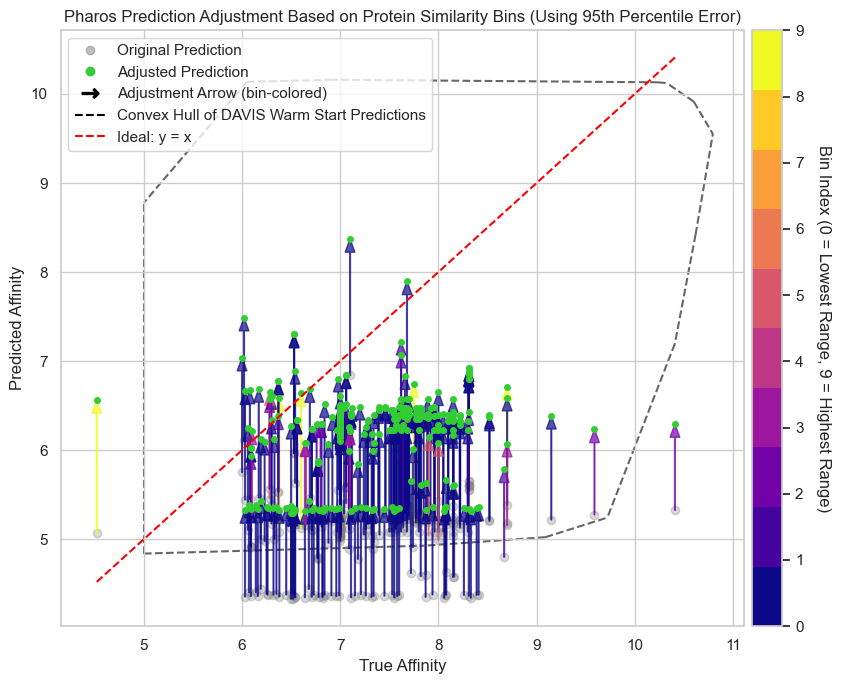

310
310
310


{'CHR': 0.0064516129032258064,
 'Mean_ERS_inside': 2.051986791892188,
 'Mean_ERS_outside': 6.763074775112504,
 'CSVS_weighted': 2.0823809079129645,
 'CSVS_chr_scaled': 0.0436327404845968}

In [26]:
evaluate_adjustment_with_similarity_bin_coloring(
    df=pharos_df,
    unblinded = unblinded,
    true_col="True_Label",
    original_pred_col="Blinded_Prediction",
    adjusted_pred_col="Adjusted_Prediction_Protein_bin",
    error_col="Expected_Error_Protein_bin",
    bin_labels_col="Similarity_Quantile_Protein",  # make sure this column exists in pharos_df
    quantile_bins=quantile_bins,                   # this should be the same bins used for colorbar
    title="Adjustment Based on Protein Similarity Bins (Using 95th Percentile Error)",
    label_suffix=" (Protein Sim)"
)
inp = pharos_df[["True_Label","Adjusted_Prediction_Protein_bin"]].values
ERS_vals_prot, dists_blinded_prot, sparsity_weights_prot, _, is_inside_prot = compute_ERS_for_points(unblinded, inp, gamma=5.0, k=20, use_cspd=False)
compute_model_level_csvs(ERS_vals_prot,is_inside_prot)

## Drug

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# === Compute similarity of each drug to the training drugs ===
def build_drug_similarity_cache(drug_embeddings, train_drugs, save_path="drug_similarity_cache.pkl"):
    similarity_cache = {}
    train_embeddings = {
        did: drug_embeddings[did]
        for did in train_drugs if did in drug_embeddings
    }

    train_vecs = np.array(list(train_embeddings.values()))
    for did, query_vec in drug_embeddings.items():
        if did not in similarity_cache:
            if query_vec is None or train_vecs.size == 0:
                similarity_cache[did] = np.nan
            else:
                sim = cosine_similarity([query_vec], train_vecs)[0]
                similarity_cache[did] = np.mean(sim)  # or np.max(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    # Check example IDs and values
    return similarity_cache


# === Compute similarity of each Pharos drug to DAVIS training drugs ===
def build_pharos_drug_similarity_cache(pharos_embeddings, davis_embeddings, save_path="pharos_drug_similarity_cache.pkl"):
    similarity_cache = {}
    print(f" Building similarity cache with {len(pharos_embeddings)} Pharos drugs and {len(davis_embeddings)} DAVIS drugs.")

    train_vecs = np.array(list(davis_embeddings.values()))
    for i, (did, query_vec) in enumerate(pharos_embeddings.items()):
        if query_vec is None or train_vecs.size == 0:
            similarity_cache[did] = np.nan
        else:
            sim = cosine_similarity([query_vec], train_vecs)[0]
            similarity_cache[did] = np.mean(sim)

    with open(save_path, "wb") as f:
        pickle.dump(similarity_cache, f)

    return similarity_cache

def predict_expected_error(similarity, model):
    """Predict expected 95th percentile error from similarity using trained quantile model."""
    X_new = np.column_stack([similarity, similarity**2])
    X_new = sm.add_constant(X_new, has_constant='add')
    return model.predict(X_new)

def predict_expected_error_drug_sim_quantiles(similarity_array, quantile_bins, quantile_values):
    expected_errors = []
    bin_labels = []
    for sim in similarity_array:
        for i, interval in enumerate(quantile_bins):
            if sim >= interval.left and sim <= interval.right:
                expected_errors.append(quantile_values[i])
                bin_labels.append(interval)
                break
        else:
            # Clamp to edge bin if similarity is out of range
            if sim < quantile_bins[0].left:
                expected_errors.append(quantile_values[0])
                bin_labels.append(quantile_bins[0])
            elif sim > quantile_bins[-1].right:
                expected_errors.append(quantile_values[-1])
                bin_labels.append(quantile_bins[-1])
            else:
                expected_errors.append(np.nan)
                bin_labels.append(np.nan)
    return np.array(expected_errors), bin_labels



In [28]:
train_drugs = merged_df["Drug_ID"]
drug_similarity_cache = build_drug_similarity_cache(drug_embeddings, train_drugs)

df["Drug_Similarity"] = df["Drug_ID"].map(drug_similarity_cache)

# Use qcut to assign protein similarity quantiles
df["Similarity_Quantile_Drug"] = pd.qcut(df["Drug_Similarity"], q=10, duplicates='drop')

# Group by quantile and compute mean error in each
#quantile_error_lookup_drug = df.groupby("Similarity_Quantile_Drug")["Percent_Error"].mean()
quantile_error_lookup_drug = df.groupby("Similarity_Quantile_Drug")["Percent_Error"].quantile(0.95)

quantile_bins_drug = df["Similarity_Quantile_Drug"].cat.categories  # stores interval bounds

# Fit quadratic quantile regression
X = df["Drug_Similarity"]
y = df["Percent_Error"]
X_poly = sm.add_constant(np.column_stack([X, X**2]))
model = sm.QuantReg(y, X_poly).fit(q=0.95)

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_67320/334693585.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_error_lookup_drug = df.groupby("Similarity_Quantile_Drug")["Percent_Error"].quantile(0.95)


In [29]:
# === 1. Build similarity cache and compute similarity values
pharos_sim_cache_drug = build_pharos_drug_similarity_cache(
    pharos_drug_embeddings, davis_drug_embeddings
)
pharos_df["Drug_Similarity"] = pharos_df["Drug_ID"].map(pharos_sim_cache_drug)

# === 2. Predict continuous expected error using quantile regression model
pharos_df["Expected_Error_Drug"] = predict_expected_error(pharos_df["Drug_Similarity"].values, model)
pharos_df["Adjusted_Prediction_Drug"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Expected_Error_Drug"] / 100)

# === 3. Adjust bins to ensure Pharos values fall within quantile intervals
# Extract bin edges from quantile_bins_drug
bin_edges = sorted(set([b.left for b in quantile_bins_drug] + [quantile_bins_drug[-1].right]))

# Extend bin edges if necessary
min_sim = pharos_df["Drug_Similarity"].min()
max_sim = pharos_df["Drug_Similarity"].max()
if min_sim < bin_edges[0]:
    bin_edges[0] = min_sim - 1e-6
if max_sim > bin_edges[-1]:
    bin_edges[-1] = max_sim + 1e-6

# Assign bin labels
pharos_df["Drug_Similarity_Bin_Label"] = pd.cut(
    pharos_df["Drug_Similarity"],
    bins=bin_edges,
    labels=quantile_bins_drug,
    include_lowest=True
)

# Map binned expected errors
bin_label_to_error = dict(zip(quantile_bins_drug, quantile_error_lookup_drug.values))
pharos_df["Expected_Error_Drug_bin"] = pharos_df["Drug_Similarity_Bin_Label"].map(bin_label_to_error).astype(float)
pharos_df["Adjusted_Prediction_Drug_bin"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Expected_Error_Drug_bin"] / 100)

# === 4. Report counts
print("\n Expected % Error by Drug Similarity Quantile:")
print(f"{'Bin Range':<25} {'% Error':<10} {'Pharos Points':<15}")
print("-" * 60)
for bin_label in quantile_bins_drug:
    err = quantile_error_lookup_drug[bin_label]
    count = (pharos_df["Drug_Similarity_Bin_Label"] == bin_label).sum()
    print(f"{str(bin_label):<25} {err:<10.2f} {count:<15}")


 Building similarity cache with 209 Pharos drugs and 68 DAVIS drugs.

 Expected % Error by Drug Similarity Quantile:
Bin Range                 % Error    Pharos Points  
------------------------------------------------------------
(0.20299999999999999, 0.228] 29.85      23             
(0.228, 0.244]            26.10      47             
(0.244, 0.254]            25.27      45             
(0.254, 0.26]             20.77      42             
(0.26, 0.268]             22.66      17             
(0.268, 0.273]            19.50      11             
(0.273, 0.278]            23.17      19             
(0.278, 0.288]            14.22      31             
(0.288, 0.307]            13.38      36             
(0.307, 0.339]            5.65       39             


 Original Predictions (Drug Sim):
   MSE = 5.346
   MAE  = 2.193

 Adjusted Predictions (+Expected % Error) (Drug Sim):
   MSE = 2.136
   MAE  = 1.282
 Improved Points: 303 / 310


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_67320/3056981007.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", n_bins)


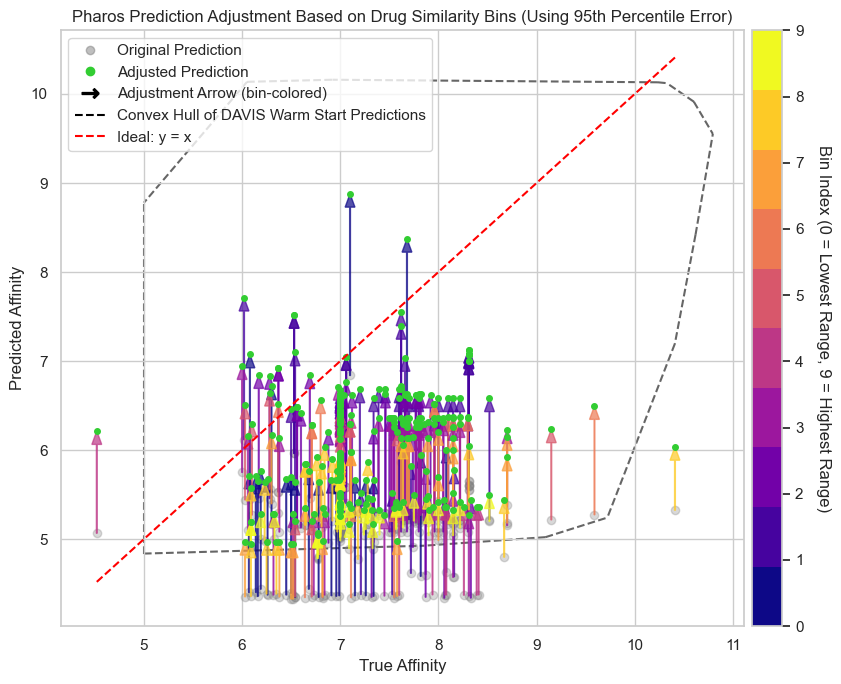

310
310
310


{'CHR': 0.0064516129032258064,
 'Mean_ERS_inside': 2.321671285901303,
 'Mean_ERS_outside': 6.900945431157801,
 'CSVS_weighted': 2.351214990064248,
 'CSVS_chr_scaled': 0.044522228588114846}

In [30]:
evaluate_adjustment_with_similarity_bin_coloring(
    df=pharos_df,
    unblinded = unblinded,
    true_col="True_Label",
    original_pred_col="Blinded_Prediction",
    adjusted_pred_col="Adjusted_Prediction_Drug_bin",
    error_col="Expected_Error_Drug_bin",
    bin_labels_col="Drug_Similarity_Bin_Label",
    quantile_bins=quantile_bins_drug,
    title="Adjustment Based on Drug Similarity Bins (Using 95th Percentile Error)",
    label_suffix=" (Drug Sim)"
)
ind = pharos_df[["True_Label","Adjusted_Prediction_Drug_bin"]].values
ERS_vals_drug, _, _, _, is_inside_drug = compute_ERS_for_points(unblinded, ind, gamma=5.0, k=20, use_cspd=False)
compute_model_level_csvs(ERS_vals_drug,is_inside_drug)


## Affinity

In [31]:
# 1. Define bins
affinity_bins = [4, 5, 6, 7, 8, 9, 10]
pharos_df["Affinity_Bin"] = pd.cut(pharos_df["Blinded_Prediction"], bins=affinity_bins)

# 2. Compute mean signed error per bin on DAVIS
bin_means = (
    df
    .assign(Affinity_Bin=pd.cut(df["Blinded_Prediction"], bins=affinity_bins))
    .groupby("Affinity_Bin")["Percent_Error"]
    .quantile(0.95)
)

# 3. Apply correction
pharos_df["Bin_Correction"] = pharos_df["Affinity_Bin"].map(bin_means).astype(float)

# 4. Adjust prediction
pharos_df["Bin_Adjusted"] = pharos_df["Blinded_Prediction"] * (1 + pharos_df["Bin_Correction"] / 100)

# 5. Optional evaluation
if "True_Label" in pharos_df:
    true = pharos_df["True_Label"]
    original = pharos_df["Blinded_Prediction"]
    adjusted = pharos_df["Bin_Adjusted"]
    
    rmse_orig = np.sqrt(mean_squared_error(true, original))
    mae_orig = mean_absolute_error(true, original)
    rmse_adj = np.sqrt(mean_squared_error(true, adjusted))
    mae_adj = mean_absolute_error(true, adjusted)
    
    print(f" Original Prediction:  RMSE={rmse_orig:.3f}, MAE={mae_orig:.3f}")
    print(f" Bin-Adjusted Prediction:  RMSE={rmse_adj:.3f}, MAE={mae_adj:.3f}")


print("\n Expected % Error by Predicted Affinity Bin:")
print(f"{'Bin Range':<15} {'% Error':<10} {'Pharos Points':<15}")
print("-" * 45)

# Reuse the same bins and bin_means used earlier
for bin_label in bin_means.index:
    err = bin_means[bin_label]
    count = (pharos_df["Affinity_Bin"] == bin_label).sum()
    print(f"{str(bin_label):<15} {err:<10.2f} {count:<15}")


 Original Prediction:  RMSE=2.312, MAE=2.193
 Bin-Adjusted Prediction:  RMSE=1.323, MAE=1.118

 Expected % Error by Predicted Affinity Bin:
Bin Range       % Error    Pharos Points  
---------------------------------------------
(4, 5]          18.60      73             
(5, 6]          24.00      234            
(6, 7]          26.90      3              
(7, 8]          27.89      0              
(8, 9]          10.44      0              
(9, 10]         nan        0              


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_67320/1161293537.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Affinity_Bin")["Percent_Error"]


 Original Predictions (Affinity):
   MSE = 5.346
   MAE  = 2.193

 Adjusted Predictions (+Expected % Error) (Affinity):
   MSE = 1.750
   MAE  = 1.118
 Improved Points: 302 / 310


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_67320/3056981007.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", n_bins)


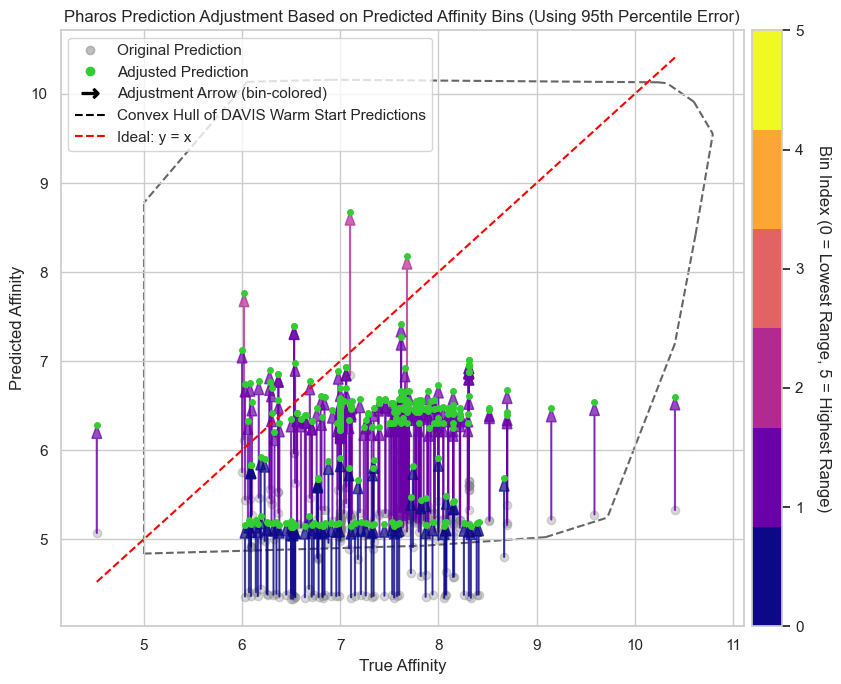

310
310
310


{'CHR': 0.0064516129032258064,
 'Mean_ERS_inside': 2.04018139889717,
 'Mean_ERS_outside': 6.589904597786505,
 'CSVS_weighted': 2.0695344517932304,
 'CSVS_chr_scaled': 0.042515513534106486}

In [32]:
pharos_df["Affinity_Bin_Label"] = pd.cut(
    pharos_df["Blinded_Prediction"],
    bins=[b.left for b in bin_means.index] + [bin_means.index[-1].right],
    labels=bin_means.index,
    include_lowest=True
)

# 7. Plot results
evaluate_adjustment_with_similarity_bin_coloring(
    df=pharos_df,
    unblinded=unblinded,
    true_col="True_Label",
    original_pred_col="Blinded_Prediction",
    adjusted_pred_col="Bin_Adjusted",
    error_col="Bin_Correction",
    bin_labels_col="Affinity_Bin_Label",
    quantile_bins=bin_means.index,
    title="Adjustment Based on Predicted Affinity Bins (Using 95th Percentile Error)",
    label_suffix=" (Affinity)"
)
ina = pharos_df[["True_Label","Bin_Adjusted"]].values
ERS_vals_aff, _, _, _, is_inside_aff = compute_ERS_for_points(unblinded, ina, gamma=5.0, k=20, use_cspd=False)
compute_model_level_csvs(ERS_vals_aff,is_inside_aff)


# MODEL BASED ERR PRED

In [33]:

import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.inspection import permutation_importance

# === Load data ===
unblinded_df = pd.read_csv("new/crossval_predictions_GINConvNet_davis_b3.csv")
blinded_df = pd.read_csv("new/concatenated_final_test_predictions.csv")
pharos_df = pd.read_csv("new/pharos_test_predictions_GINConvNet.csv")

# === Rename prediction columns ===
unblinded_df = unblinded_df.rename(columns={"Predicted_Value": "Unblinded_Prediction"})
blinded_df = blinded_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})
pharos_df = pharos_df.rename(columns={"Predicted_Value": "Blinded_Prediction"})

blinded_df["Drug_ID"] = blinded_df["Drug_ID"].astype(str)
unblinded_df["Drug_ID"] = unblinded_df["Drug_ID"].astype(str)

# === Merge DAVIS unblinded and blinded ===
merged_df = pd.merge(
    unblinded_df[["Drug_ID", "Protein_ID", "True_Label", "Unblinded_Prediction"]],
    blinded_df[["Drug_ID", "Protein_ID", "True_Label", "Blinded_Prediction"]],
    on=["Drug_ID", "Protein_ID", "True_Label"]
)


unblinded = merged_df[["True_Label", "Unblinded_Prediction"]].values
blinded = merged_df[["True_Label", "Blinded_Prediction"]].values
pharos = pharos_df[["True_Label", "Blinded_Prediction"]].values

_,is_inside = compute_continuous_hull_distance(unblinded, blinded)
blinded_df["Is_Inside"] = is_inside

outside_mask = ~blinded_df["Is_Inside"]
#THIS LINE CONTROLS IF ONLY OUTSIDE DATA IS USED FOR TRAINING THE MODEL!!!!
#merged_df = merged_df[outside_mask]

# === Percent Error Target ===
merged_df["Signed_Percent_Error"] = (
    100 * (merged_df["Unblinded_Prediction"] - merged_df["Blinded_Prediction"]) / merged_df["True_Label"]
)
print(merged_df["Signed_Percent_Error"].describe())


# === Filter for available embeddings ===
davis_merged = merged_df[
    merged_df["Drug_ID"].isin(davis_drug_embeddings) &
    merged_df["Protein_ID"].isin(davis_protein_embeddings)
].copy()

# === Similarity Feature Function ===
def compute_similarity_features(df, drug_embs, prot_embs, train_drug_embs, train_prot_embs):
    ref_drug_vecs = np.stack(list(train_drug_embs.values()))
    ref_prot_vecs = np.stack(list(train_prot_embs.values()))
    features = []
    for _, row in df.iterrows():
        did, pid = row["Drug_ID"], row["Protein_ID"]
        if did not in drug_embs or pid not in prot_embs:
            features.append([np.nan] * 4)
            continue
        drug_sim = cosine_similarity([drug_embs[did]], ref_drug_vecs)[0]
        prot_sim = cosine_similarity([prot_embs[pid]], ref_prot_vecs)[0]
        features.append([
            np.mean(drug_sim), np.max(drug_sim),
            np.mean(prot_sim), np.max(prot_sim)
        ])
    return pd.DataFrame(features, columns=[
        "Drug_Sim_Mean", "Drug_Sim_Max", "Prot_Sim_Mean", "Prot_Sim_Max"
    ])

# === Compute similarity features ===
sim_feats = compute_similarity_features(
    davis_merged,
    drug_embs=davis_drug_embeddings,
    prot_embs=davis_protein_embeddings,
    train_drug_embs=davis_drug_embeddings,
    train_prot_embs=davis_protein_embeddings
)
davis_merged = pd.concat([davis_merged.reset_index(drop=True), sim_feats.reset_index(drop=True)], axis=1)

# === Extra Features ===
min_davis_unblinded = davis_merged["Unblinded_Prediction"].min()
davis_merged["Below_Train_Min"] = (davis_merged["Blinded_Prediction"] < min_davis_unblinded).astype(int)
davis_merged["Confidence_Proxy"] = davis_merged["Drug_Sim_Mean"] * davis_merged["Prot_Sim_Mean"]

# === Model training data ===
X_train = davis_merged[[
    "Blinded_Prediction", "Drug_Sim_Mean", "Drug_Sim_Max",
    "Prot_Sim_Mean", "Prot_Sim_Max", "Confidence_Proxy"
]]
y_train = davis_merged["Signed_Percent_Error"]


reg = HistGradientBoostingRegressor(max_iter=300, random_state=42)
reg.fit(X_train, y_train)

# === Interpret model (optional) ===
perm_importances = permutation_importance(reg, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_importances.importances_mean,
    "Std": perm_importances.importances_std
})
# }).sort_values(by="Importance", ascending=False)
print(importance_df)




count    27621.000000
mean         3.876866
std          9.053374
min        -46.713672
25%         -0.066246
50%          2.106726
75%          5.739054
max         79.087120
Name: Signed_Percent_Error, dtype: float64
              Feature  Importance       Std
0  Blinded_Prediction    0.635578  0.004937
1       Drug_Sim_Mean    0.300608  0.004185
2        Drug_Sim_Max    0.058222  0.001334
3       Prot_Sim_Mean    0.550652  0.005393
4        Prot_Sim_Max    0.229142  0.002548
5    Confidence_Proxy    0.140477  0.002241


In [34]:

# === Prepare Pharos features ===
pharos_sim_feats = compute_similarity_features(
    pharos_df,
    drug_embs=pharos_drug_embeddings,
    prot_embs=pharos_protein_embeddings,
    train_drug_embs=davis_drug_embeddings,
    train_prot_embs=davis_protein_embeddings
)
pharos_df_sim = pd.concat([pharos_df.reset_index(drop=True), pharos_sim_feats], axis=1)

pharos_df_sim["Confidence_Proxy"] = (
    pharos_df_sim["Drug_Sim_Mean"] * pharos_df_sim["Prot_Sim_Mean"]
)

X_pharos = pharos_df_sim[[
    "Blinded_Prediction", "Drug_Sim_Mean", "Drug_Sim_Max",
    "Prot_Sim_Mean", "Prot_Sim_Max", "Confidence_Proxy"
]]

# === Predict % Error ===
pharos_df_sim["Predicted_Signed_Percent_Error"] = reg.predict(X_pharos)
pharos_df_sim["Adjusted_Prediction"] = pharos_df_sim["Blinded_Prediction"] * (
    1 + pharos_df_sim["Predicted_Signed_Percent_Error"] / 100
)

print(pharos_df_sim["Predicted_Signed_Percent_Error"].describe())
print(pharos_df_sim["Adjusted_Prediction"].describe())


count    310.000000
mean      10.534155
std        5.105600
min       -3.374784
25%        5.797880
50%       11.161718
75%       14.179815
max       24.574038
Name: Predicted_Signed_Percent_Error, dtype: float64
count    310.000000
mean       5.608097
std        0.428131
min        4.810670
25%        5.343994
50%        5.543435
75%        5.885538
max        7.688895
Name: Adjusted_Prediction, dtype: float64


In [35]:
inm = pharos_df_sim[["True_Label","Adjusted_Prediction"]].values
ERS_vals_mod, _, _, _, is_inside_mod = compute_ERS_for_points(unblinded, inm, gamma=5.0, k=20, use_cspd=False)
compute_model_level_csvs(ERS_vals_mod,is_inside_mod)

310
310
310


{'CHR': 0.04516129032258064,
 'Mean_ERS_inside': 3.008718106768865,
 'Mean_ERS_outside': 5.381952438994034,
 'CSVS_weighted': 3.1158964314500013,
 'CSVS_chr_scaled': 0.24305591659973055}

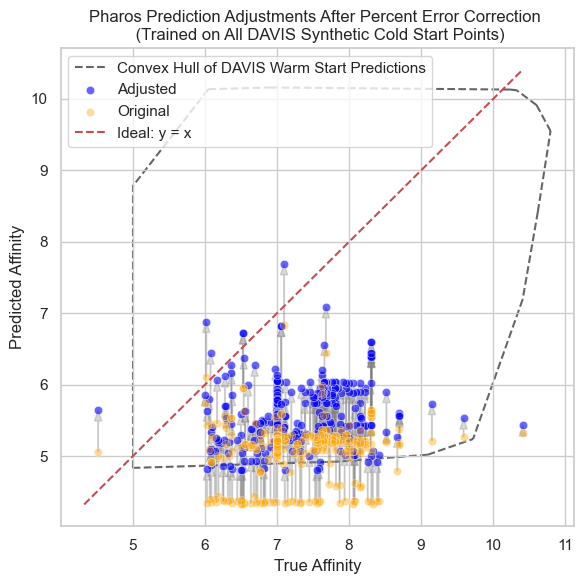

Original MSE: 5.346479689084604
Adjusted MSE: 3.322768342073261
Original MAE: 2.19277850483871
Adjusted MAE: 1.6816559380664147


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# === Convex Hull of Original Predictions ===
# Construct 2D array of (True_Label, Blinded_Prediction)
points = unblinded
plotted_hull = False  # Flag to avoid adding multiple legend entries
if len(points) >= 3:
    try:
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            # Add label only to the first segment to show in the legend
            label = "Convex Hull of DAVIS Warm Start Predictions" if not plotted_hull else None
            plt.plot(
                points[simplex, 0], points[simplex, 1],
                color='black', linestyle='--', linewidth=1.5, alpha=0.6, zorder=0, label=label
            )
            plotted_hull = True
    except Exception as e:
        print(f"Warning: Could not compute convex hull — {e}")

# Plot arrows: original → adjusted
for _, row in pharos_df_sim.iterrows():
    plt.arrow(
        row["True_Label"], row["Blinded_Prediction"],
        0, row["Adjusted_Prediction"] - row["Blinded_Prediction"],
        color='gray', alpha=0.3, width=0.01, head_width=0.1, length_includes_head=True
    )

# Scatter adjusted points
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Adjusted_Prediction"],
    color="blue", label="Adjusted", alpha=0.6
)

# Scatter original predictions
sns.scatterplot(
    x=pharos_df_sim["True_Label"],
    y=pharos_df_sim["Blinded_Prediction"],
    color="orange", label="Original", alpha=0.4
)

# y = x line
lims = [
    min(pharos_df_sim["True_Label"].min(), pharos_df_sim["Blinded_Prediction"].min(), pharos_df_sim["Adjusted_Prediction"].min()),
    max(pharos_df_sim["True_Label"].max(), pharos_df_sim["Blinded_Prediction"].max(), pharos_df_sim["Adjusted_Prediction"].max())
]
plt.plot(lims, lims, 'r--', label='Ideal: y = x')

plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Pharos Prediction Adjustments After Percent Error Correction \n (Trained on All DAVIS Synthetic Cold Start Points)") #(Trained on All DAVIS Blinded Points)
plt.legend()
plt.tight_layout()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

true = pharos_df_sim["True_Label"]
orig = pharos_df_sim["Blinded_Prediction"]
adj = pharos_df_sim["Adjusted_Prediction"]

print("Original MSE:", mean_squared_error(true, orig))
print("Adjusted MSE:", mean_squared_error(true, adj))
print("Original MAE:", (mean_absolute_error(true, orig)))
print("Adjusted MAE:", (mean_absolute_error(true, adj)))

Outside only:

              Feature  Importance       Std
0  Blinded_Prediction    0.917004  0.021417
3       Prot_Sim_Mean    0.356988  0.014963
5    Confidence_Proxy    0.122980  0.004143
1       Drug_Sim_Mean    0.105785  0.003682
4        Prot_Sim_Max    0.077054  0.005200
2        Drug_Sim_Max    0.076950  0.005119


count    310.000000
mean      25.289450
std        8.682288
min        5.543272
25%       23.299324
50%       28.280346
75%       31.521560
max       37.025101
Name: Predicted_Signed_Percent_Error, dtype: float64
count    310.000000
mean       6.389284
std        0.827114
min        4.650104
25%        6.391525
50%        6.708469
75%        6.860148
max        8.443192
Name: Adjusted_Prediction, dtype: float64

Original MSE: 5.346479689084604
Adjusted MSE: 1.8030523840677672
Original MAE: 2.19277850483871
Adjusted MAE: 1.015262883730384

{'CHR': 0.15483870967741936,
 'Mean_ERS_inside': 1.470021605747757,
 'Mean_ERS_outside': 5.574265514170343,
 'CSVS_weighted': 2.1055174367293192,
 'CSVS_chr_scaled': 0.8631120796134726}

Both inside and outside: 

              Feature  Importance       Std
0  Blinded_Prediction    0.620966  0.004465
3       Prot_Sim_Mean    0.573325  0.005844
1       Drug_Sim_Mean    0.246054  0.003074
4        Prot_Sim_Max    0.226804  0.002128
5    Confidence_Proxy    0.201653  0.002158
2        Drug_Sim_Max    0.054996  0.001384




count    310.000000
mean       7.024420
std        4.833835
min       -4.372000
25%        3.608495
50%        6.354676
75%       10.358723
max       19.661688
Name: Predicted_Signed_Percent_Error, dtype: float64
count    310.000000
mean       5.429132
std        0.404087
min        4.762734
25%        5.189446
50%        5.388466
75%        5.596330
max        7.860505
Name: Adjusted_Prediction, dtype: float64

Original MSE: 5.346479689084604
Adjusted MSE: 3.9565619511984567
Original MAE: 2.19277850483871
Adjusted MAE: 1.8596736127391669

 {'CHR': 0.08064516129032258,
 'Mean_ERS_inside': 3.1201927976583903,
 'Mean_ERS_outside': 5.39014507264501,
 'CSVS_weighted': 3.303253464996021,
 'CSVS_chr_scaled': 0.43468911876169436}